In [75]:
# Load environment variables and set up auto-reload
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
from utils import show_prompt
from cad_agent_from_scratch.prompts import PLAN_DESIGN_INTENT_PROMPT
show_prompt(PLAN_DESIGN_INTENT_PROMPT, "Plan Design Intent Prompt")

╭─────────────────────────────────────────── Plan Design Intent Prompt ───────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  You are a CAD Planning Agent.                                                                                  │
│                                                                                                                 │
│  You are given a FINALIZED CAD design intent and its structured interpretation.                                 │
│  Your task is to produce a HIGH-LEVEL CAD DESIGN PLAN that will be reviewed and                                 │
│  approved by a human BEFORE any CAD code is written.                                                            │
│                                                                                                                 │
│  You are NOT designing geometry.                                                                                │
│  You are NOT inventing structure.                                                                               │
│  You are articulating a clear plan based strictly on the clarified intent.                                      │
│                                                                                                                 │
│  --------------------------------------------------                                                             │
│  INPUT CONTEXT                                                                                                  │
│  --------------------------------------------------                                                             │
│                                                                                                                 │
│  Finalized Design Intent (human-readable):                                                                      │
│  <DesignIntent>                                                                                                 │
│  {design_intent}                                                                                                │
│  </DesignIntent>                                                                                                │
│                                                                                                                 │
│  Parsed Design Intent (structured, explicit facts only):                                                        │
│  <ParsedIntent>                                                                                                 │
│  {parsed_intent}                                                                                                │
│  </ParsedIntent>                                                                                                │
│                                                                                                                 │
│  Human Feedback (if any, from previous review):                                                                 │
│  <HumanFeedback>                                                                                                │
│  {human_feedback}                                                                                               │
│  </HumanFeedback>                                                                                               │
│                                                                                                                 │
│  If HumanFeedback is "None", generate the initial plan.                                                         │
│  If HumanFeedback is present, revise the plan ONLY to address that feedback,                                    │
│  without introducing new components or assumptions.   

In [77]:
%%writefile ../src/cad_agent_from_scratch/design_planning_state.py

"""
State Definitions and Pydantic Schemas for CAD Design Planning.

This module defines the state extensions and structured schemas used for
the Planning step of an agentic CAD workflow.

Responsibilities:
- Extend the shared CAD state with planning artifacts
- Define structured LLM output schemas for design planning
- NO workflow logic
"""

from typing_extensions import Optional, Annotated, Sequence

from langchain_core.messages import BaseMessage
from langgraph.graph import MessagesState
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field

from cad_agent_from_scratch.logger import logging

# =============================================================================
# MODULE INIT LOG
# =============================================================================

logging.info("Loaded design_planning_state module")

# =============================================================================
# STATE DEFINITIONS
# =============================================================================

class DesignPlanningState(MessagesState):
    """
    Extended state for the CAD design planning step.

    Builds on the clarified design intent and introduces:
    - A human-readable design plan
    - Human-in-the-loop approval signals
    - Iterative refinement support
    """

    # Human-readable, component-wise design plan
    design_plan: Optional[str]

    # Messages exchanged during planning refinements
    plan_messages: Annotated[Sequence[BaseMessage], add_messages]

    # Human approval flag (controls progression to coding)
    human_approved: bool = False

    # Optional human feedback when plan is rejected
    human_feedback: Optional[str]


logging.info("Registered DesignPlanningState")

# =============================================================================
# STRUCTURED OUTPUT SCHEMAS (LLM)
# =============================================================================

class PlanDesignIntent(BaseModel):
    """
    Schema used by the Planning agent to propose a CAD design plan.

    The plan must be:
    - Human-readable
    - Component-wise
    - Approximate and semantic
    - Free of implementation details
    """

    design_plan: str = Field(
        description=(
            "A clear, human-readable, component-wise CAD design plan. "
            "Must describe major components, approximate proportions, and "
            "high-level structure. No code, no coordinates, no primitives."
        )
    )

    ready_for_review: bool = Field(
        description=(
            "Whether the generated plan is ready for human review and approval."
        )
    )


logging.info("Registered PlanDesignIntent schema")


Overwriting ../src/cad_agent_from_scratch/design_planning_state.py


In [78]:
%%writefile ../src/cad_agent_from_scratch/design_planning_workflow.py

"""
Design Planning Workflow (CAD).

This module implements Step-2 of the agentic CAD workflow:
1. Generate a high-level, human-readable design plan
2. Present the plan for human approval
3. Loop until approval is granted

Architecture mirrors design_intent_workflow and deep_research scoping patterns.
"""

from typing_extensions import Literal
import sys

from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command

from cad_agent_from_scratch.design_planning_state import (
    DesignPlanningState,
    PlanDesignIntent,
)

from cad_agent_from_scratch.prompts import (
    PLAN_DESIGN_INTENT_PROMPT,
)

from cad_agent_from_scratch.logger import logging
from cad_agent_from_scratch.exception import CustomException

# =============================================================================
# MODEL CONFIGURATION
# =============================================================================

model = init_chat_model(
    model="gpt-4.1-mini",
    temperature=0.0,
)

logging.info("Initialized CAD design planning workflow model")

# =============================================================================
# WORKFLOW NODES
# =============================================================================

def generate_design_plan(
    state: DesignPlanningState,
) -> Command[Literal["check_human_approval"]]:
    """
    Generate a high-level CAD design plan from clarified intent.
    """

    logging.info("Entered node: generate_design_plan")

    design_intent = state.get("design_intent")
    parsed_intent = state.get("parsed_intent")
    human_feedback = state.get("human_feedback")

    try:
        structured_model = model.with_structured_output(PlanDesignIntent)

        prompt_text = PLAN_DESIGN_INTENT_PROMPT.format(
            design_intent=design_intent,
            parsed_intent=parsed_intent,
            human_feedback=human_feedback or "None"
        )

        logging.debug(f"Planning prompt:\n{prompt_text}")

        response = structured_model.invoke(
            [HumanMessage(content=prompt_text)]
        )

        logging.info("Design plan generated successfully")
        logging.debug(f"Planning response object: {response}")

    except Exception as e:
        logging.exception("Error during generate_design_plan LLM call")
        raise CustomException(e, sys)

    return Command(
        goto="check_human_approval",
        update={
            "design_plan": response.design_plan,
            "plan_messages": [AIMessage(content=response.design_plan)],
        },
    )


def check_human_approval(
    state: DesignPlanningState,
) -> Command[Literal["generate_design_plan", "__end__"]]:
    """
    Decide whether to proceed or refine the design plan based on human approval.
    """

    logging.info("Entered node: check_human_approval")

    approved = state.get("human_approved", False)

    if approved:
        logging.info("Human approved the design plan — exiting planning workflow")
        return Command(goto=END)

    logging.info("Design plan not approved — looping back to planner")
    return Command(goto="generate_design_plan")

# =============================================================================
# GRAPH CONSTRUCTION
# =============================================================================

logging.info("Building LangGraph for design planning workflow")

builder = StateGraph(DesignPlanningState)

builder.add_node("generate_design_plan", generate_design_plan)
builder.add_node("check_human_approval", check_human_approval)

builder.add_edge(START, "generate_design_plan")
builder.add_edge("generate_design_plan", "check_human_approval")

design_planning_workflow = builder.compile()

logging.info("Design planning workflow compiled successfully")

Overwriting ../src/cad_agent_from_scratch/design_planning_workflow.py


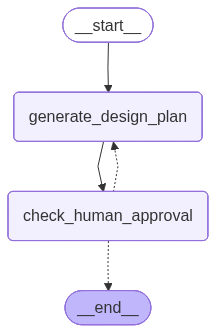

In [81]:
from langgraph.checkpoint.memory import InMemorySaver
from IPython.display import Image, display

from cad_agent_from_scratch.design_planning_workflow import builder

# In-memory checkpointing for interactive runs
checkpointer = InMemorySaver()

# Compile the planning workflow with checkpointing
scope = builder.compile(checkpointer=checkpointer)

# Visualize the Planning workflow graph
display(Image(scope.get_graph(xray=True).draw_mermaid_png()))

In [82]:
# Run the CAD design planning workflow
from utils import format_messages
from cad_agent_from_scratch.design_planning_workflow import builder

thread = {"configurable": {"thread_id": "11"}}


# Invoke Planning workflow
result = scope.invoke(
    {
        "design_intent": "Design a solid cube with a side length of 50 units.",
        "parsed_intent": {
            "object_name": "cube",
            "components": ['cube'],
            "dimensions": {"side_length": "50 units"},
            "configuration": "solid",
            "assumptions": None
        },
        "human_approved": True   # 🔑 stop condition
    },
    config=thread
)

format_messages(result.get("plan_messages", []))

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 1. No components are specified in the design intent, so no design plan can be formulated at this time.          │
│                                                                                                                 │
│ Approval Question:                                                                                              │
│ Does this plan look good to proceed with CAD modeling?                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [83]:
result["design_plan"]

'1. No components are specified in the design intent, so no design plan can be formulated at this time.\n\nApproval Question:\nDoes this plan look good to proceed with CAD modeling?'